In [3]:
import pandas as pd
from datetime import datetime, timedelta
import os
from tqdm import tqdm
import pickle
tqdm.pandas()
import warnings
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# from submission_xgboost.utils import create_features_and_target
# from submission_xgboost.utils import create_features_for_prediction
warnings.filterwarnings("ignore")

### Load Initial position and dict of Omni

In [19]:
initial_states = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/00000_to_02284-initial_states.csv')
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/02285_to_02357-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/02358_to_04264-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/04265_to_05570-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/05571_to_05614-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/05615_to_06671-initial_states.csv')])
initial_states = pd.concat([initial_states,pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/06672_to_08118-initial_states.csv')])
initial_states['Timestamp'] = pd.to_datetime(initial_states['Timestamp'])

# add last data
#df_temp = pd.read_csv('C:/Users/isaac/Documents/Challenge_MIT_2/mit_challenge_2/data/phase_1/06672_to_08118-initial_states.csv')
# df_temp['Timestamp'] = pd.to_datetime(df_temp['Timestamp'])
# initial_states = pd.concat([initial_states,df_temp])
initial_states = initial_states.set_index('File ID')
print(initial_states.shape)
initial_states =  initial_states.mask((initial_states==9.99e+29)|(initial_states==9.99e+32))
initial_states = initial_states.loc[initial_states.count(1)==10]
print(initial_states.shape)

(8119, 10)
(8095, 10)


In [12]:
with open('data/data_isaac/omni.pickle', 'rb') as f:
    omni = pickle.load(f)
with open('data/data_isaac/sat.pickle', 'rb') as f:
    sat = pickle.load(f)

In [5]:
# all_files_omni = os.listdir("phase_1/omni2/")
# all_files_dens = os.listdir("phase_1/sat_density/")
# omni = {}
# for i in tqdm(all_files_omni):
#     omni[int(i.split('-')[1])] = pd.read_csv('phase_1/omni2/'+i)
# sat = {}
# for i in tqdm(all_files_dens):
#     sat[int(i.replace('gr-of','grof').split('-')[1])] = pd.read_csv('phase_1/sat_density/'+i)
# with open('omni.pickle', 'wb') as handle:
#     pickle.dump(omni, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('sat.pickle', 'wb') as handle:
#     pickle.dump(sat, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
all_features = []
all_target = []
for i in tqdm(range(6672)):
    data_omni = omni[i]
    data_omni['Timestamp'] = pd.to_datetime(data_omni['Timestamp'],format='%Y-%m-%d %H:%M:%S')
    data_omni = data_omni.ffill()
    data_sat = sat[i]
    data_sat['Timestamp'] = pd.to_datetime(data_sat['Timestamp'],format='%Y-%m-%d %H:%M:%S')
    df_features = pd.merge_ordered(data_omni,initial_states.iloc[[i]],how='outer',on='Timestamp')
    df_features = df_features.ffill().bfill()
    all_features.append(df_features.drop(['Timestamp','YEAR', 'DOY', 'Hour'],axis=1).T.to_numpy())
    all_target.append(np.pad(data_sat['Orbit Mean Density (kg/m^3)'].to_numpy(), [(0, 433 - len(data_sat['Orbit Mean Density (kg/m^3)'].to_numpy()))], mode='constant', constant_values=0))
#df_features = pd.merge_ordered(df_features,data_omni,how='outer')              

100%|█████████████████████████████████████████████████████████████████████████████| 6672/6672 [00:44<00:00, 151.26it/s]


In [24]:
initial_states

,Timestamp,Semi-major Axis (km),Eccentricity,Inclination (deg),RAAN (deg),Argument of Perigee (deg),True Anomaly (deg),Latitude (deg),Longitude (deg),Altitude (km)
File ID,,,,,,,,,,
0,2000-08-02 04:50:33,6826.387247,0.003882,87.275306,144.135111,257.314389,102.383270,43.637815,-62.543128,466.448890
1,2000-08-03 19:51:01,6826.327748,0.003879,87.275694,143.529694,250.438806,109.273118,43.444458,70.139709,463.435053
2,2000-08-05 05:40:05,6819.634802,0.004114,87.268611,142.972111,244.549389,115.138737,19.764250,104.521278,471.625453
3,2000-08-06 05:02:20,6819.606603,0.004134,87.268194,142.608389,241.172000,118.545161,12.450738,112.239558,470.385914
4,2000-08-08 20:54:57,6819.425918,0.004178,87.264611,141.605111,228.779611,130.982981,-8.776992,-130.559634,468.911226
...,...,...,...,...,...,...,...,...,...,...
8114,2019-12-25 00:00:00,6765.013678,0.005730,87.863978,102.587920,240.608198,187.758342,69.535173,108.291937,443.930606
8115,2019-12-27 00:00:00,6801.130577,0.002172,90.690901,99.760357,152.602156,226.350702,20.225336,99.507926,435.492910
8116,2019-12-28 00:00:00,6805.864837,0.001925,91.053632,96.918243,43.442569,131.160787,4.265831,-83.003782,436.652863



###  Model by MSIS

In [7]:
from submission_presistence.atm_me import PersistenceMSIS, MSISPersistenceAtmosphere, PersistenceModel

In [22]:
model = PersistenceModel(plot_trajectory=True)

In [25]:
initial_states.loc[id].to_dict()

{'Timestamp': Timestamp('2001-02-11 12:44:36'),
 'Semi-major Axis (km)': 6815.969666613082,
 'Eccentricity': 0.0036834001075476,
 'Inclination (deg)': 87.264,
 'RAAN (deg)': 71.71630555555556,
 'Argument of Perigee (deg)': 223.3065833333333,
 'True Anomaly (deg)': 136.54355047659027,
 'Latitude (deg)': 30.303778283286963,
 'Longitude (deg)': -83.06833655301996,
 'Altitude (km)': 432.9132206807891}

Starting propagation...: 100%|███████████████████████████████████████████████████████| 431/431 [02:54<00:00,  2.47it/s]


Time interval [s]: 259200.0
Time step [s]: 600.0
CPU time [s]: 176.66706728935242
Final Pos [km]: 6828.3232243934235
Final Vel [km]: 7.623377252377472


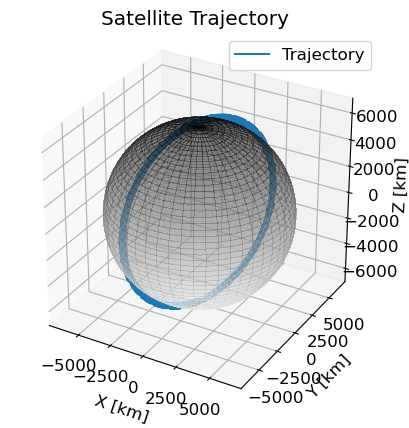

In [28]:
id = 100
omni_data = omni[id].loc[:,['Timestamp', 'f10.7_index', 'ap_index_nT']]
omni_data['Timestamp'] = pd.to_datetime(omni_data['Timestamp'])
omni_data = omni_data.ffill()
states, densities = model(omni_data,initial_states.loc[id].to_dict())
predictions = model._convert_to_df(states, densities)

In [21]:
predictions

,Timestamp,Density (kg/m3)
0,2001-02-11 12:44:36+00:00,3.237395e-19
1,2001-02-11 12:54:36+00:00,2.329309e-19
2,2001-02-11 13:04:36+00:00,1.103575e-19
3,2001-02-11 13:14:36+00:00,1.034000e-19
4,2001-02-11 13:24:36+00:00,7.144513e-20
...,...,...
427,2001-02-14 11:54:36+00:00,2.579564e-19
428,2001-02-14 12:04:36+00:00,3.155120e-19
429,2001-02-14 12:14:36+00:00,3.309032e-19
430,2001-02-14 12:24:36+00:00,2.406894e-19


In [8]:
bad_id = []

In [ ]:
model = PersistenceModel(plot_trajectory=False)
for id in df_train.index:
    if os.path.exists('data_isaac/sat_density_pred_no_drag/density_pred'+ str(id) + '.csv'):
        continue
    else:
        bad_id.append(id)
        continue
    omni_data = omni[id].loc[:,['Timestamp', 'f10.7_index', 'ap_index_nT']]
    omni_data['Timestamp'] = pd.to_datetime(omni_data['Timestamp'])
    omni_data = omni_data.ffill()
    try:
        states, densities = model(omni_data,df_train.loc[id].to_dict())
        predictions = model._convert_to_df(states, densities)
        predictions.to_csv('data_isaac/sat_density_pred_no_drag/density_pred'+ str(id) + '.csv')
    except:
        print(id)